## 0. Imports, Paths and Helper Functions

### 0.1 Imports

In [1]:
import json
import psycopg2
import itertools
import pickle




import numpy             as np
import pandas            as pd
import seaborn           as sns
import matplotlib.pyplot as plt



from IPython.core.display  import HTML
from IPython.display       import Image
from tabulate              import tabulate
from boruta                import BorutaPy
from sklearn.ensemble      import RandomForestClassifier
from sklearn.preprocessing import RobustScaler, StandardScaler,MinMaxScaler
from sklearn.tree          import DecisionTreeClassifier, ExtraTreeClassifier

from scipy                 import stats           as ss

### 0.2 Paths

In [2]:
data = '../data/'
raw  = 'raw/'
interim = 'interim/'
processed = 'processed/'

modules_path = '../models/'

images_path = '../reports/figures/'

### 0.3 Helper Functions

In [3]:
def cramer_v(x,y):
    cm = pd.crosstab(x,y).values
    n = cm.sum()
    r,k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0,chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr=k - (k-1)**2/(n-1) 
    rcorr=r - (r-1)**2/(n-1) 
    
    v = np.sqrt( (chi2corr/n) / (min (kcorr-1,rcorr-1)))
    return v


def categorical_feature_correlation(df_cat):
    cat_list = df_cat.columns.to_list()
    dic_corr = {cat : [] for cat in cat_list}
    
    for a,b in itertools.product(cat_list,repeat=2):
        dic_corr[a].append(cramer_v(df_cat[a],df_cat[b]))

    return pd.DataFrame(dic_corr,index=cat_list)


def cat_info(ax,total,size = 25,file=False):
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height,
                '{:1.2f}%'.format(height/total*100),
                ha="center",size=size) 
    plt.show()
    
    
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [4]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 6.0 Feature Selection

In [5]:
df6 = pd.read_csv(data+processed+'train_processed.csv')

x_train_n = df6.drop(['id','response'],axis=1).values
y_train_n = df6['response'].values


### 6.1 Feature Selection by Importance

In [6]:
etc = ExtraTreeClassifier(random_state=42)
dtc = DecisionTreeClassifier(random_state=42)

In [7]:
etc.fit(x_train_n,y_train_n)
dtc.fit(x_train_n,y_train_n)

aux = pd.DataFrame({'features': df6.drop(['id','response'],axis=1).columns,
                    'ExtraTreeClassifier': etc.feature_importances_, 
                    'DecisionTreeClassifier':dtc.feature_importances_})
aux

,features,ExtraTreeClassifier,DecisionTreeClassifier
0,gender,0.009035,0.028226
1,age,0.173323,0.134197
2,region_code,0.085538,0.094766
3,policy_sales_channel,0.060569,0.052700
4,driving_license,0.000678,0.000472
5,vehicle_age,0.003934,0.010492
6,vehicle_damage,0.125651,0.125651
7,previously_insured,0.013924,0.012038
8,annual_premium,0.243601,0.266364
9,vintage,0.283747,0.275093


<AxesSubplot:xlabel='DecisionTreeClassifier', ylabel='features'>

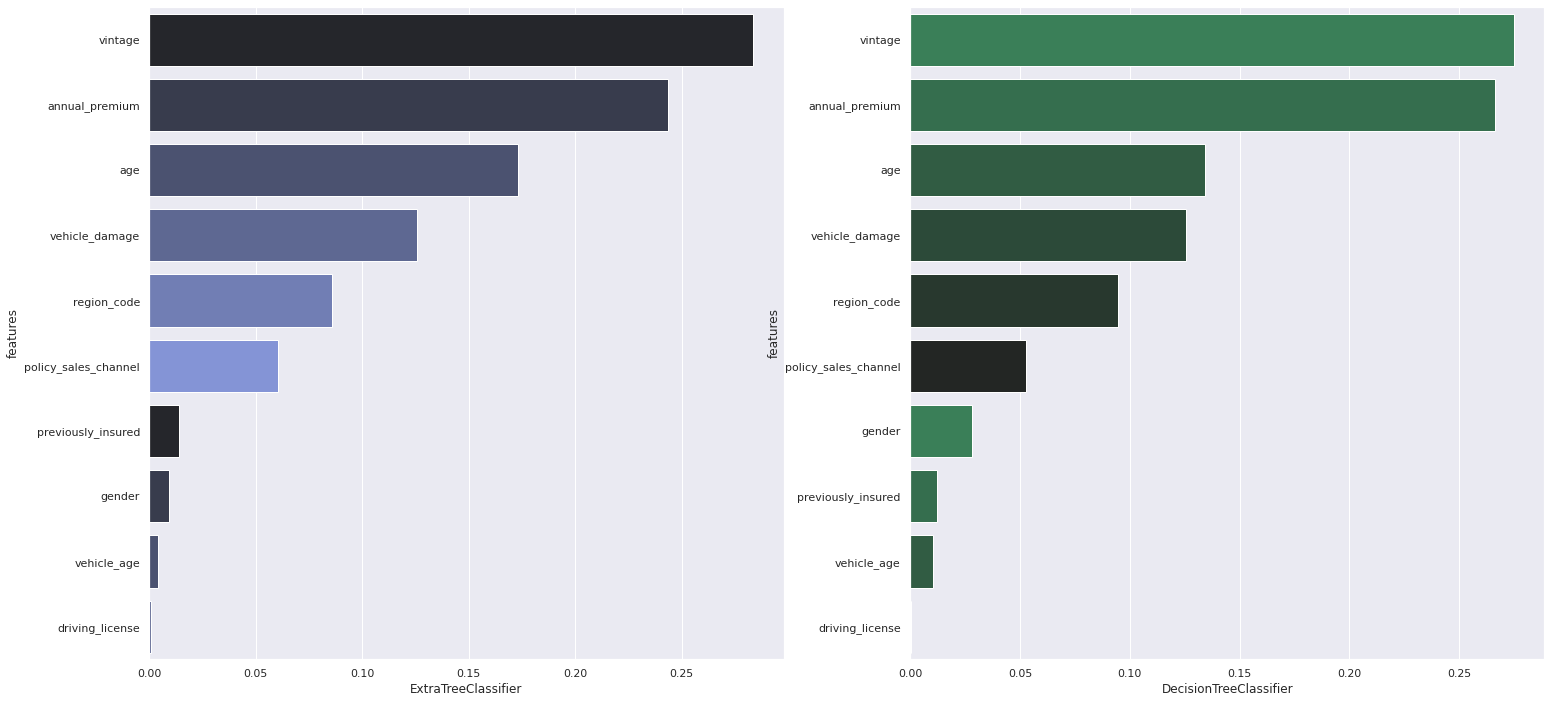

In [8]:
aux2 = aux.sort_values('ExtraTreeClassifier',ascending = False)
plt.subplot(121)
sns.barplot(y='features', x='ExtraTreeClassifier',data = aux2,palette=sns.dark_palette((260, 75, 60), input="husl"))


aux2 = aux.sort_values('DecisionTreeClassifier',ascending = False)
plt.subplot(122)
sns.barplot(y='features', x='DecisionTreeClassifier',data = aux2,palette=sns.dark_palette("seagreen", reverse=True))

### 6.2 Feature Selection Using Boruta

In [9]:
rf = RandomForestClassifier(n_estimators=150)

boruta = BorutaPy(rf, n_estimators='auto',verbose=0, random_state=42).fit(x_train_n,y_train_n)

In [12]:
cs = df6.drop(columns = ['id','response']).loc[:,boruta.support_.tolist()].columns
cs.tolist()

['age']

(OBS: The Imabalanced data can be the origin of boruta confusion! See this e the next cycle!)

### 6.3 Features selected

In [11]:
selected_cols = ['vintage',
                 'annual_premium',
                 'age',
                 'vehicle_damage',
                 'region_code',
                 'policy_sales_channel']